# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [192]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale
from itertools import combinations

In [193]:
df = pd.read_csv('../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


<Axes: xlabel='ACTION', ylabel='count'>

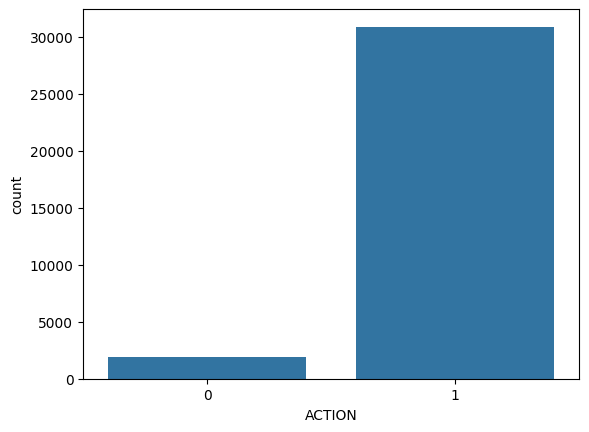

In [194]:
print(df['ACTION'].mean())
sns.countplot(x='ACTION', data=df)

In [195]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [196]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

<span style="background-color: #FFDAB9; color: black">
Ответ: наша модель достаточно часто достаточно часто готова выдавать доступ сотруднику, когда фактически его должны были бы отклонить
</span>

'              precision    recall  f1-score   support\n\n           0       0.22      0.03      0.05      1534\n           1       0.94      0.99      0.97     24682\n\n    accuracy                           0.94     26216\n   macro avg       0.58      0.51      0.51     26216\nweighted avg       0.90      0.94      0.91     26216\n'

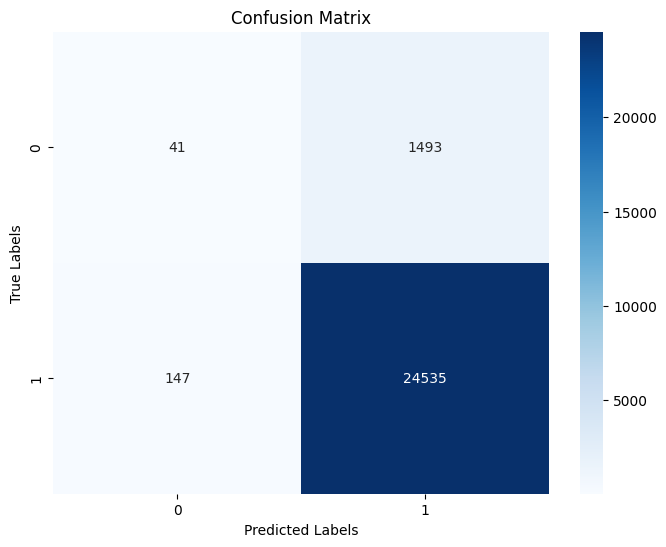

In [197]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, p=2)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Отчет о классификации
classification_report_1 = classification_report(y_test, y_pred)
display(classification_report_1)

# Построение confusion matrix
cm = confusion_matrix(y_test, y_pred)

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [198]:
p_values = [1, 2, 4, 6]

# Результаты метрик для разных p
results = {}

for p in p_values:
    knn = KNeighborsClassifier(n_neighbors=10, p=p)
    
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    
    results[p] = {
        'mean': np.mean(scores),
        'std': np.std(scores)
    }

for p, metrics in results.items():
    print(f"p = {p}: mean = {metrics['mean']:.4f}, std = {metrics['std']:.4f}")

# p с максимальной метрикой
best_p = max(results, key=lambda k: results[k]['mean'])
print(f"\n Значение p c максимальной метрикой: {best_p}, mean = {results[best_p]['mean']:.4f}")

p = 1: mean = 0.9443, std = 0.0010
p = 2: mean = 0.9446, std = 0.0008
p = 4: mean = 0.9445, std = 0.0009
p = 6: mean = 0.9441, std = 0.0006

 Значение p c максимальной метрикой: 2, mean = 0.9446


# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [199]:
'''Задание странно сформулировано, поэтому поменял изначальный код
Кроме того, заккоментирую эту часть, чтобы она не мешала второй части задания'''

# data = pd.DataFrame(index=df.index)


# for col_name in df.columns:
#     if col_name == 'ACTION':
#         continue

#     stats = df.groupby(col_name)['ACTION'].agg(['count', 'sum']).rename(columns={'count': 'counts', 'sum': 'successes'})

#     data[f'{col_name}_counts'] = df[col_name].map(stats['counts'])
#     data[f'{col_name}_successes'] = df[col_name].map(stats['successes'])
#     data[f'{col_name}_smooth_ratio'] = (data[f'{col_name}_successes'] + 1) / (data[f'{col_name}_counts'] + 2)

'Задание странно сформулировано, поэтому поменял изначальный код\nКроме того, заккоментирую эту часть, чтобы она не мешала второй части задания'

In [200]:
# Теперь для фолдов
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

# Целевая переменная
y_train = df_train['ACTION']
y_test = df_test['ACTION']

# Обучающие данные с фолдингом
data = pd.DataFrame(index=df_train.index)
test_data = pd.DataFrame(index=df_test.index)

n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for col_name in df.columns:
    if col_name == 'ACTION':
        continue

    counts = np.zeros(len(df_train))
    successes = np.zeros(len(df_train))

    for train_idx, val_idx in kf.split(df_train):
        train, val = df_train.iloc[train_idx], df_train.iloc[val_idx]
        stats = train.groupby(col_name)['ACTION'].agg(['count', 'sum']).rename(
            columns={'count': 'counts', 'sum': 'successes'}
        )

        counts[val_idx] = val[col_name].map(stats['counts']).fillna(0).to_numpy()
        successes[val_idx] = val[col_name].map(stats['successes']).fillna(0).to_numpy()

    data[f'{col_name}_counts'] = counts
    data[f'{col_name}_successes'] = successes
    data[f'{col_name}_smooth_ratio'] = (successes + 1) / (counts + 2)

    stats = df_train.groupby(col_name)['ACTION'].agg(['count', 'sum']).rename(
        columns={'count': 'counts', 'sum': 'successes'}
    )
    test_data[f'{col_name}_counts'] = df_test[col_name].map(stats['counts']).fillna(0).to_numpy()
    test_data[f'{col_name}_successes'] = df_test[col_name].map(stats['successes']).fillna(0).to_numpy()
    test_data[f'{col_name}_smooth_ratio'] = (
        test_data[f'{col_name}_successes'] + 1
    ) / (test_data[f'{col_name}_counts'] + 2)

# data.fillna(0, inplace=True)
# test_data.fillna(0, inplace=True)




Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [201]:
# Кросс-валидация для обучения модели
scores = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
n_classes = len(np.unique(y_train))  # Количество классов (у нас - 2, но мало ли)
aggregate_cm = np.zeros((n_classes, n_classes), dtype=int)

for train_idx, val_idx in kf.split(data):
    X_train, X_val = data.iloc[train_idx], data.iloc[val_idx]
    y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Обучение модели на фолде
    knn = KNeighborsClassifier(n_neighbors=5, p=2)
    knn.fit(X_train, y_train_fold)

    # Предсказания
    y_pred = knn.predict(X_val)

    # Оценка метрики
    score = classification_report(y_val, y_pred, output_dict=True)
    scores.append(score)

    # Получение confusion matrix для текущего фолда
    cm = confusion_matrix(y_val, y_pred, labels=np.arange(n_classes))
    aggregate_cm += cm  # Суммирование матриц ошибок

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

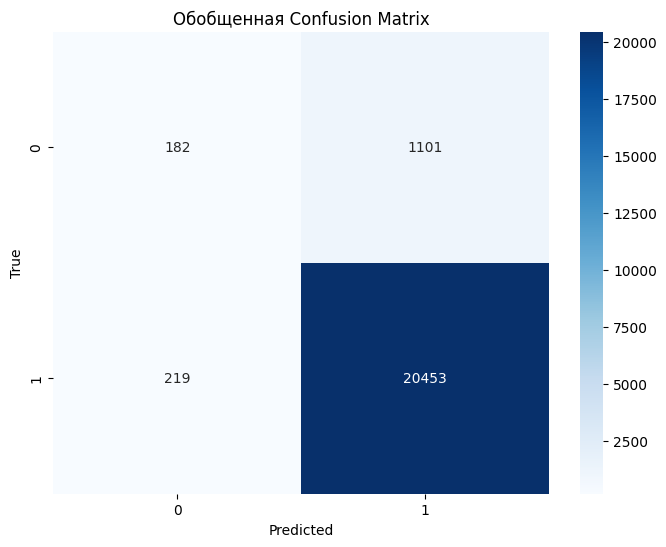

In [202]:
# Построение итоговой heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(aggregate_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(n_classes), yticklabels=np.arange(n_classes))
plt.title("Обобщенная Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [203]:
all_reports = []
for report in scores:
    rep_df = pd.DataFrame(report).transpose()
    all_reports.append(rep_df)

# Вычисляем средние значения
mean_report = pd.concat(all_reports).groupby(level=0).mean()
print("Было\n", classification_report_1)
print("Стало\n", mean_report)


Было
               precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216

Стало
               precision    recall  f1-score      support
0              0.454216  0.142101  0.216335   427.666667
1              0.948919  0.989406  0.968738  6890.666667
accuracy       0.939877  0.939877  0.939877     0.939877
macro avg      0.701568  0.565754  0.592536  7318.333333
weighted avg   0.920016  0.939877  0.924755  7318.333333


<span style="background-color: #FFDAB9; color: black">
Ответ: в среднем по палате, метрики стали выше
</span>

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [204]:
# Здесь всё то же самое, что и выше, но в виде функции
def evaluate_with_folds(df, target_column='ACTION', n_folds=3, n_neighbors=5):
    # Разделение данных на train/test
    df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    # Подготовка обучающих данных с фолдингом
    data = pd.DataFrame(index=df_train.index)
    test_data = pd.DataFrame(index=df_test.index)

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for col_name in df.columns:
        if col_name == target_column:
            continue

        counts = np.zeros(len(df_train))
        successes = np.zeros(len(df_train))

        # Фолдинг
        for train_idx, val_idx in kf.split(df_train):
            train, val = df_train.iloc[train_idx], df_train.iloc[val_idx]
            stats = train.groupby(col_name)[target_column].agg(['count', 'sum']).rename(
                columns={'count': 'counts', 'sum': 'successes'}
            )

            counts[val_idx] = val[col_name].map(stats['counts']).fillna(0).to_numpy()
            successes[val_idx] = val[col_name].map(stats['successes']).fillna(0).to_numpy()

        data[f'{col_name}_counts'] = counts
        data[f'{col_name}_successes'] = successes
        data[f'{col_name}_smooth_ratio'] = (successes + 1) / (counts + 2)

        # Для тестовой выборки
        stats = df_train.groupby(col_name)[target_column].agg(['count', 'sum']).rename(
            columns={'count': 'counts', 'sum': 'successes'}
        )
        test_data[f'{col_name}_counts'] = df_test[col_name].map(stats['counts']).fillna(0).to_numpy()
        test_data[f'{col_name}_successes'] = df_test[col_name].map(stats['successes']).fillna(0).to_numpy()
        test_data[f'{col_name}_smooth_ratio'] = (
            test_data[f'{col_name}_successes'] + 1
        ) / (test_data[f'{col_name}_counts'] + 2)

    # Кросс-валидация
    scores = []
    n_classes = len(np.unique(y_train))
    aggregate_cm = np.zeros((n_classes, n_classes), dtype=int)

    for train_idx, val_idx in kf.split(data):
        X_train, X_val = data.iloc[train_idx], data.iloc[val_idx]
        y_train_fold, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Обучение модели на фолде
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2)
        knn.fit(X_train, y_train_fold)

        # Предсказания
        y_pred = knn.predict(X_val)

        # Оценка метрики
        score = classification_report(y_val, y_pred, output_dict=True)
        scores.append(score)

        # Confusion matrix для фолда
        cm = confusion_matrix(y_val, y_pred, labels=np.arange(n_classes))
        aggregate_cm += cm

    # Построение итоговой heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        aggregate_cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=np.arange(n_classes),
        yticklabels=np.arange(n_classes)
    )
    plt.title("Обобщенная Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Средние значения метрик
    all_reports = []
    for report in scores:
        df_report = pd.DataFrame(report).transpose()
        all_reports.append(df_report)

    mean_report = pd.concat(all_reports).groupby(level=0).mean()
    print("Средний отчет классификации:")
    print(mean_report)

    return mean_report, aggregate_cm

In [205]:
# Без разделения данных. Тоже уже было сверху
def evaluate_without_folds(df, target_column='ACTION', test_size=0.33, n_neighbors=5):
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    data = pd.DataFrame(index=df_train.index)
    test_data = pd.DataFrame(index=df_test.index)

    for col_name in df.columns:
        if col_name == target_column:
            continue

        stats = df_train.groupby(col_name)[target_column].agg(['count', 'sum']).rename(
            columns={'count': 'counts', 'sum': 'successes'}
        )

        data[f'{col_name}_counts'] = df_train[col_name].map(stats['counts']).fillna(0).to_numpy()
        data[f'{col_name}_successes'] = df_train[col_name].map(stats['successes']).fillna(0).to_numpy()
        data[f'{col_name}_smooth_ratio'] = (data[f'{col_name}_successes'] + 1) / (data[f'{col_name}_counts'] + 2)

        test_data[f'{col_name}_counts'] = df_test[col_name].map(stats['counts']).fillna(0).to_numpy()
        test_data[f'{col_name}_successes'] = df_test[col_name].map(stats['successes']).fillna(0).to_numpy()
        test_data[f'{col_name}_smooth_ratio'] = (
            test_data[f'{col_name}_successes'] + 1
        ) / (test_data[f'{col_name}_counts'] + 2)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2)
    knn.fit(data, y_train)

    y_pred = knn.predict(test_data)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test)
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return classification_report(y_test, y_pred), cm

C:\Users\Simon\AppData\Local\Temp\ipykernel_20144\920836647.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col_name}_successes'] = successes
C:\Users\Simon\AppData\Local\Temp\ipykernel_20144\920836647.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col_name}_smooth_ratio'] = (successes + 1) / (counts + 2)
C:\Users\Simon\AppData\Local\Temp\ipykernel_20144\920836647.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

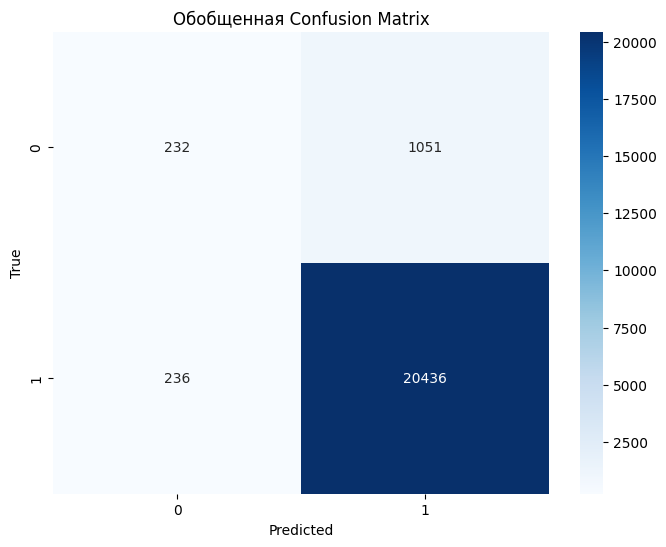

Средний отчет классификации:
              precision    recall  f1-score      support
0              0.494943  0.181356  0.265284   427.666667
1              0.951088  0.988583  0.969471  6890.666667
accuracy       0.941380  0.941380  0.941380     0.941380
macro avg      0.723015  0.584970  0.617378  7318.333333
weighted avg   0.924412  0.941380  0.928287  7318.333333


In [206]:
# С кросс-валидацией
df_combo = df.copy()

for col1, col2 in combinations(df.columns, 2):
    if col1 == 'ACTION' or col2 == 'ACTION':
        continue
    new_col_name = f"{col1}_{col2}"
    df_combo[new_col_name] = df[col1].astype(str) + "_" + df[col2].astype(str)

report_with_folds, aggregate_cm = evaluate_with_folds(df_combo)


C:\Users\Simon\AppData\Local\Temp\ipykernel_20144\1153214213.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col_name}_successes'] = df_train[col_name].map(stats['successes']).fillna(0).to_numpy()
C:\Users\Simon\AppData\Local\Temp\ipykernel_20144\1153214213.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col_name}_smooth_ratio'] = (data[f'{col_name}_successes'] + 1) / (data[f'{col_name}_counts'] + 2)
C:\Users\Simon\AppData\Local\Temp\ipykernel_20144\1153214213.py:23: PerformanceWarning: DataFrame is hig

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.29      0.38       614
           1       0.96      0.98      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.74      0.64      0.67     10814
weighted avg       0.93      0.94      0.94     10814



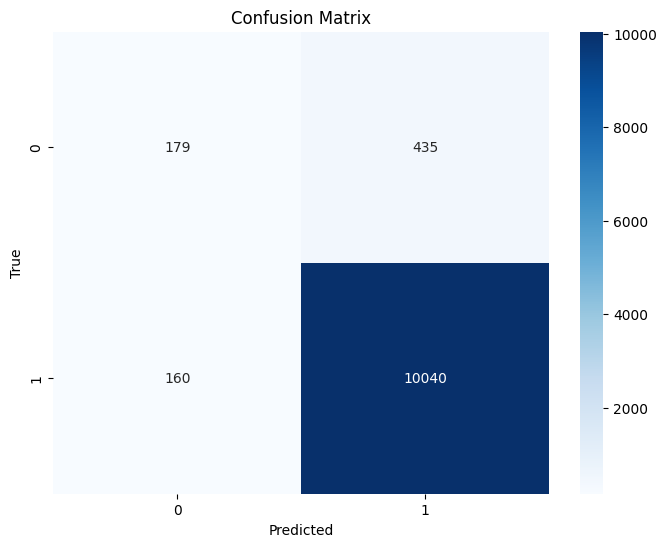

In [207]:
# Без кросс-валидации
report_without_folds, cm = evaluate_without_folds(df_combo)

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

In [208]:
print("Упрощённый метод\n", report_without_folds)
print("С фолдами\n", report_with_folds)

Упрощённый метод
               precision    recall  f1-score   support

           0       0.53      0.29      0.38       614
           1       0.96      0.98      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.74      0.64      0.67     10814
weighted avg       0.93      0.94      0.94     10814

С фолдами
               precision    recall  f1-score      support
0              0.494943  0.181356  0.265284   427.666667
1              0.951088  0.988583  0.969471  6890.666667
accuracy       0.941380  0.941380  0.941380     0.941380
macro avg      0.723015  0.584970  0.617378  7318.333333
weighted avg   0.924412  0.941380  0.928287  7318.333333



<span style="background-color: #FFDAB9; color: black">
Ответ: неожиданно, упрощённый метод показал лучший результат. На переобучение это не похоже, раньше результаты были скромнее  
</span>

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [209]:
df_target = df.copy()

In [210]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    # Группируем по целевой переменной и считаем среднее для каждого признака
    grouped_mean = df_target.groupby('ACTION')[col_name].transform('mean')

    # Заменяем значения в столбце на среднее для соответствующего класса
    data_target[col_name] = df_target[col_name].map(grouped_mean)

In [211]:
print(data_target.head())

       RESOURCE        MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0           NaN           NaN            NaN            NaN            NaN   
1  42925.487205  25942.943735            NaN            NaN            NaN   
2           NaN  26737.799157            NaN            NaN            NaN   
3           NaN  25942.943735            NaN            NaN            NaN   
4           NaN  25942.943735            NaN            NaN            NaN   

   ROLE_TITLE  ROLE_FAMILY_DESC    ROLE_FAMILY  ROLE_CODE  
0         NaN               NaN            NaN        NaN  
1         NaN               NaN            NaN        NaN  
2         NaN               NaN  183715.916656        NaN  
3         NaN               NaN            NaN        NaN  
4         NaN               NaN  183715.916656        NaN  


Сравните результаты. 

Какой недостаток есть у target encoding?



<span style="background-color: #FFDAB9; color: black">Ответ: видимо, чтобы применять target encoding принципиально важно не иметь пропусков в данных. В интернете пишут про возможность переобучения (та же идея, что была высказана в материале выше, когда модель может получить доступ к целевой переменной)  
</span>